# <span style="color:blue">EVAC Workshop 5: Basic neural evolution</span>

**Module leader**

Simon O'Keefe: simon.okeefe@york.ac.uk

**Graduate Teaching Assistants**

Danny Roberts: danny.roberts@york.ac.uk

Tianda Sun: tianda.sun@york.ac.uk

## <span style="color:#0073e6">Prerequisites</span>

Before participating in this practical make sure that you have watched the neural network lectures

## <span style="color:#0073e6">Topics</span>

- Basic neural evolution

## <span style="color:#0073e6">Learning objectives</span>

- To understand how to evolve weights in a static topology neural network


# <span style="color:blue">Exercise: evolving weights of simple MLP</span>

In this practical you will evolve weights of a simple MLP with a static structure.

# <span style="color:blue">Task: evolving weights of simple MLP</span>

The problem that you will address is the 'exclusive OR' problem (XOR). We are using this problem, because it is simple, yet it is known that a hidden layer is needed in a MPL to solve this problem because it is not linearly separable. The XOR problem takes in two binary inputs and outputs a 1 if either are a one, but not both:

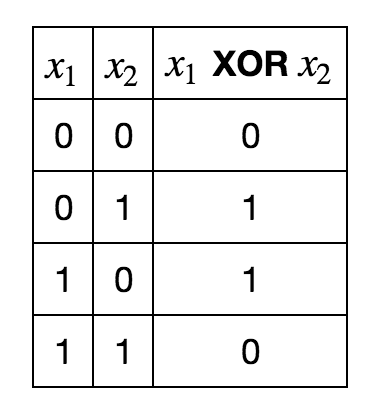



# <span style="color:blue">Defining a simple neural network</span>

There are packages out there dedicated to producing neural networks, such as Tensorflow and Pytorch. However, for simplicity we will implement our own basic MLP, fully-connected and hard-coded with just one hidden layer. This is implemented the same as in the walkthrough. **However, for speed, this implementation has only one hidden layer.**

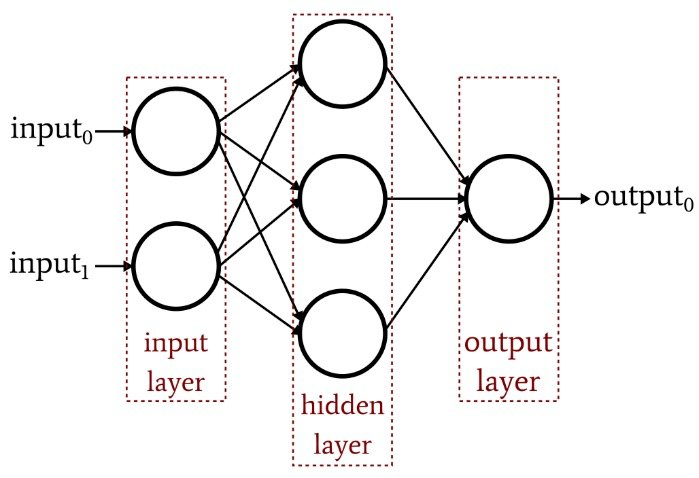


We start by defining a class for our network:

In [2]:
import numpy as np
import math


class MLP(object):
    def __init__(self, numInput, numHidden, numOutput):
        self.fitness = 0
        self.numInput = numInput + 1  # Add bias node to inputs
        self.numHidden = numHidden
        self.numOutput = numOutput

        self.wh = np.random.randn(self.numHidden, self.numInput)
        self.wo = np.random.randn(self.numOutput, self.numHidden)

        self.ReLU = lambda x: max(0, x)

    def sigmoid(self, x):
        try:
            ans = 1 / (1 + math.exp(-x))
        except OverflowError:
            ans = float("inf")
        return ans

First we define the feedforward function of our network. To do this, we simply take the dot product of the input array and the weights from that input to the next layer of nodes. We then run those weighted sums through the ReLU function in the hidden layer, and the sigmoid in the last layer. This makes it similar to a non-linear regression problem.

In [3]:
class MLP(MLP):
    def feedForward(self, inputs):
        inputsBias = inputs[:]
        inputsBias.insert(len(inputs), 1)  # Add bias input
        h1 = np.dot(self.wh, inputsBias)  # feed to hidden layer
        h1 = [self.ReLU(x) for x in h1]  # Activate hidden layer
        output = np.dot(self.wo, h1)  # feed to output layer
        output = [self.sigmoid(x) for x in output]  # Activate output layer
        return output

Next we define functions that allow the genetic algorithm to get and set the weights as a simple one-dimensional list. This means we can then just work with the built-in operators without having to worry about defining our own to work with multidimensional arrays.

In [12]:
class MLP(MLP):
    def getWeightsLinear(self):
        flat_wh = list(self.wh.flatten())
        flat_wo = list(self.wo.flatten())
        return flat_wh + flat_wo

    def setWeightsLinear(self, Wgenome):
        numWeights_IH = self.numHidden * (self.numInput)
        self.wh = np.array(Wgenome[:numWeights_IH])
        self.wh = self.wh.reshape((self.numHidden, self.numInput))
        self.wo = np.array(Wgenome[numWeights_IH:])
        self.wo = self.wo.reshape((self.numOutput, self.numHidden))

We will create a multi-layer perceptron with 2 inputs, 3 hidden nodes (in a single hidden layer), and 1 output.

In [5]:
myNet = MLP(2, 3, 1)

In [41]:
myNet.getWeightsLinear()

12

It takes in a list of size 2, and gives a list as output, with each element in the list being the output nodes (here we only have 1).

In [7]:
inputs = [0, 1]

In [9]:
outcome = myNet.feedForward(inputs)
outcome

[0.4426464812367533]

The outcome will be between 0 and 1, due to the sigmoid function. To make this binary we can add a step function.

In [10]:
print(outcome)

[0.4426464812367533]


In [11]:
int(outcome[0] > 0.5)

0

# <span style="color:blue">Exercise: Implement your Genetic Algorithm Here</span>

In [62]:
def evaluate(ind, myNet: MLP):
    myNet.setWeightsLinear(ind)
    predictions = [myNet.feedForward(inp) for inp in [[0, 0], [0, 1], [1, 0], [1, 1]]]
    return (
        sum(
            [
                int(prediction[0] > 0.5) == actual
                for (prediction, actual) in zip(predictions, [0, 1, 1, 0])
            ]
        ),
    )

In [63]:
from deap import base, creator, tools
import random

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1.0, 1.0)
toolbox.register(
    "individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=12
)

toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.5, indpb=0.1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
logbook = tools.Logbook()

pop = toolbox.population(n=100)

In [64]:
fitnesses = [toolbox.evaluate(indiv, myNet) for indiv in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit
NGEN = 20

for g in range(NGEN):
    print("-- Generation %i --" % g)

    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(indiv, myNet) for indiv in invalid_ind]
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    pop[:] = offspring
    record = stats.compile(pop)
    logbook.record(gen=g, **record)

-- Generation 0 --
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
-- Generation 5 --
-- Generation 6 --
-- Generation 7 --
-- Generation 8 --
-- Generation 9 --
-- Generation 10 --
-- Generation 11 --
-- Generation 12 --
-- Generation 13 --
-- Generation 14 --
-- Generation 15 --
-- Generation 16 --
-- Generation 17 --
-- Generation 18 --
-- Generation 19 --


Text(0, 0.5, 'Mean Fitness')

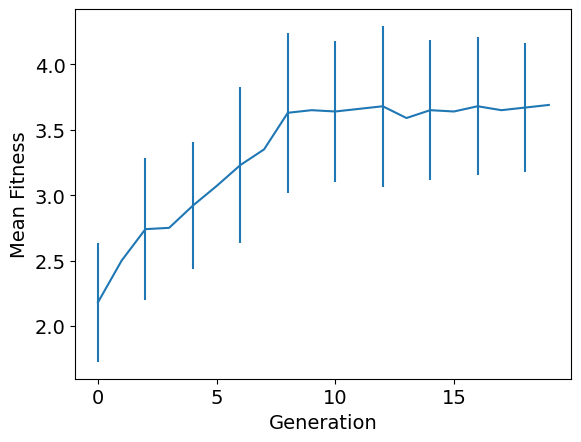

In [65]:
import matplotlib.pyplot as plt

logbook.header = "gen", "avg", "evals", "std", "min", "max"


%matplotlib inline
gen = logbook.select("gen")
avgs = logbook.select("avg")
stds = logbook.select("std")
plt.rc("axes", labelsize=14)
plt.rc("xtick", labelsize=14)
plt.rc("ytick", labelsize=14)
plt.rc("legend", fontsize=14)

fig, ax1 = plt.subplots()
# line1 = ax1.plot(gen, avgs)
line1 = ax1.errorbar(gen, avgs, yerr=stds, errorevery=2)
ax1.set_xlabel("Generation")
ax1.set_ylabel("Mean Fitness")